### Salary prediction, episode II: make it actually work (4 points)

Your main task is to use some of the tricks you've learned on the network and analyze if you can improve __validation MAE__. Try __at least 3 options__ from the list below for a passing grade. Write a short report about what you have tried. More ideas = more bonus points. 

__Please be serious:__ " plot learning curves in MAE/epoch, compare models based on optimal performance, test one change at a time. You know the drill :)

You can use either __pytorch__ or __tensorflow__ or any other framework (e.g. pure __keras__). Feel free to adapt the seminar code for your needs. For tensorflow version, consider `seminar_tf2.ipynb` as a starting point.


# 0. Prepare data
Its just Ctrl+x -> Ctrl+v from seminar

In [ ]:
import numpy as np
import pandas as pd
import nltk
from tqdm.auto import tqdm
from sklearn.feature_extraction import DictVectorizer
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline

!wget https://ysda-seminars.s3.eu-central-1.amazonaws.com/Train_rev1.zip
data = pd.read_csv("./Train_rev1.zip", compression='zip', index_col=None)
data['Log1pSalary'] = np.log1p(data['SalaryNormalized']).astype('float32')

text_columns = ["Title", "FullDescription"]
categorical_columns = ["Category", "Company", "LocationNormalized", "ContractType", "ContractTime"]
TARGET_COLUMN = "Log1pSalary"

data[categorical_columns] = data[categorical_columns].fillna('NaN') 

tokenizer = nltk.tokenize.WordPunctTokenizer()
data["FullDescription"] = data["FullDescription"].apply(lambda x: " ".join(tokenizer.tokenize(x.lower())))
data["Title"]           = data["Title"].apply(lambda x: " ".join(tokenizer.tokenize(str(x).lower())))

from collections import Counter
token_counts = Counter()
for title in data["Title"]:
    token_counts.update(title.split())
for desc in data["FullDescription"]:
    token_counts.update(desc.split())
    
min_count = 10
tokens = sorted(t for t, c in token_counts.items() if c >= min_count) #TODO<YOUR CODE HERE>
UNK, PAD = "UNK", "PAD"
tokens = [UNK, PAD] + tokens

token_to_id = {w : i for i, w in enumerate(tokens)}

In [12]:
UNK_IX, PAD_IX = map(token_to_id.get, [UNK, PAD])
def as_matrix(sequences, max_len=None):
    """ Convert a list of tokens into a matrix with padding """
    if isinstance(sequences[0], str):
        sequences = list(map(str.split, sequences))
    max_len = min(max(map(len, sequences)), max_len or float('inf'))
    max_len = max(max_len, 5)
    matrix = np.full((len(sequences), max_len), np.int32(PAD_IX))
    for i,seq in enumerate(sequences):
        row_ix = [token_to_id.get(word, UNK_IX) for word in seq[:max_len]]
        matrix[i, :len(row_ix)] = row_ix
    return matrix

top_companies, top_counts = zip(*Counter(data['Company']).most_common(1000))
recognized_companies = set(top_companies)
data["Company"] = data["Company"].apply(lambda comp: comp if comp in recognized_companies else "Other")
categorical_vectorizer = DictVectorizer(dtype=np.float32, sparse=False)
categorical_vectorizer.fit(data[categorical_columns].apply(dict, axis=1))

data_train, data_val = train_test_split(data, test_size=0.2, random_state=42)
data_train.index = range(len(data_train))
data_val.index = range(len(data_val))

--2022-10-02 17:32:49--  https://ysda-seminars.s3.eu-central-1.amazonaws.com/Train_rev1.zip
Resolving ysda-seminars.s3.eu-central-1.amazonaws.com (ysda-seminars.s3.eu-central-1.amazonaws.com)... 52.219.170.170
Connecting to ysda-seminars.s3.eu-central-1.amazonaws.com (ysda-seminars.s3.eu-central-1.amazonaws.com)|52.219.170.170|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 128356352 (122M) [application/zip]
Saving to: ‘Train_rev1.zip.2’

Train_rev1.zip.2    100%[===================>] 122.41M  11.3MB/s    in 11s     

2022-10-02 17:33:00 (11.0 MB/s) - ‘Train_rev1.zip.2’ saved [128356352/128356352]

Train size =  195814
Validation size =  48954


In [13]:
import torch
import torch.nn as nn
import torch.functional as F

device = 'cuda' if torch.cuda.is_available() else 'cpu'

def to_tensors(batch, device):
    batch_tensors = dict()
    for key, arr in batch.items():
        if key in ["FullDescription", "Title"]:
            batch_tensors[key] = torch.tensor(arr, device=device, dtype=torch.int64)
        else:
            batch_tensors[key] = torch.tensor(arr, device=device)
    return batch_tensors


def make_batch(data, max_len=None, word_dropout=0, device=device):
    """
    Creates a keras-friendly dict from the batch data.
    :param word_dropout: replaces token index with UNK_IX with this probability
    :returns: a dict with {'title' : int64[batch, title_max_len]
    """
    batch = {}
    batch["Title"] = as_matrix(data["Title"].values, max_len)
    batch["FullDescription"] = as_matrix(data["FullDescription"].values, max_len)
    batch['Categorical'] = categorical_vectorizer.transform(data[categorical_columns].apply(dict, axis=1))
    
    if word_dropout != 0:
        batch["FullDescription"] = apply_word_dropout(batch["FullDescription"], 1. - word_dropout)
    
    if TARGET_COLUMN in data.columns:
        batch[TARGET_COLUMN] = data[TARGET_COLUMN].values
    
    return to_tensors(batch, device)

def apply_word_dropout(matrix, keep_prop, replace_with=UNK_IX, pad_ix=PAD_IX,):
    dropout_mask = np.random.choice(2, np.shape(matrix), p=[keep_prop, 1 - keep_prop])
    dropout_mask &= matrix != pad_ix
    return np.choose(dropout_mask, [matrix, np.full_like(matrix, replace_with)])

def iterate_minibatches(data, batch_size=256, shuffle=True, cycle=False, device=device, **kwargs):
    """ iterates minibatches of data in random order """
    while True:
        indices = np.arange(len(data))
        if shuffle:
            indices = np.random.permutation(indices)
        for start in range(0, len(indices), batch_size):
            batch = make_batch(data.iloc[indices[start : start + batch_size]], device=device, **kwargs)
            yield batch
        if not cycle: break
        

def print_metrics(model, data, batch_size=BATCH_SIZE, name="", **kw):
    squared_error = abs_error = num_samples = 0.0
    model.eval()
    with torch.no_grad():
        for batch in iterate_minibatches(data, batch_size=batch_size, shuffle=False, **kw):
            batch_pred = model(batch)
            squared_error += torch.sum(torch.square(batch_pred - batch[TARGET_COLUMN]))
            abs_error += torch.sum(torch.abs(batch_pred - batch[TARGET_COLUMN]))
            num_samples += len(batch_pred)
    mse = squared_error.detach().cpu().numpy() / num_samples
    mae = abs_error.detach().cpu().numpy() / num_samples
    print("%s results:" % (name or ""))
    print("Mean square error: %.5f" % mse)
    print("Mean absolute error: %.5f" % mae)
    return mse, mae

# 1. CNN architecture

All the tricks you know about dense and convolutional neural networks apply here as well.
* Added Dropout - for input. Like data augmentation. It help us not overtraining.
* Added Batch Norm after Conv. For faster convergence. 
* Added RELU for creating non-linear model.
* Added parallel Conv layers with another kernel size for accumulate more global context. 
* Used Adam istead of SGD

In the training relust below we see that metrics monotonically insreases. But little bit slower then original implementation in seminar notebook. Probably its happend because we use drop out and model trained with more stable way. She look at the different data every time.

In [74]:
class TextEncoder(nn.Module):
      def __init__(self, n_tokens, hid_size, pool="max"):
        super().__init__()
        self.emb   = torch.nn.Embedding(n_tokens, hid_size*2)
        self.drop  = nn.Dropout(p=0.1)
        self.conv1 = torch.nn.Conv1d(hid_size*2, hid_size, 3)
        self.bn1   = torch.nn.BatchNorm1d(hid_size)
        self.relu1 = torch.nn.ReLU()
        self.conv2 = torch.nn.Conv1d(hid_size*2, hid_size, 5, 2)
        self.bn2   = torch.nn.BatchNorm1d(hid_size)
        self.relu2 = torch.nn.ReLU()
        if pool == "max":
            self.pool  = self.maxpool
        elif pool == "avg":
            self.pool = self.avgpool
        elif pool == "softmax":
            self.pool = self.softmaxpool
      
      def maxpool(self, x):
        return x.max(dim=-1).values
    
      def avgpool(self, x):
        return x.mean(dim=-1)
    
      def softmaxpool(self, x):
#         print(x.shape, torch.nn.Softmax(dim=1)(x).shape)
        return (x * torch.nn.Softmax(dim=2)(x)).sum(-1)

      def forward(self, x):                 # N x SEQ_LEN
        x = self.emb(x).transpose(-1, -2)   # N x EMB_LEN x SEQ_LEN
        x = self.drop(x)                    # N x EMB_LEN x SEQ_LEN
        
        x1 = self.relu1(self.bn1(self.conv1(x)))  # N x HID_SIZE x SEQ_LEN_1
        x2 = self.relu2(self.bn2(self.conv2(x)))  # N x HID_SIZE x SEQ_LEN_2
        
        x = torch.cat([x1, x2], -1)    # N x HID_SIZE x [SEQ_LEN_1 + SEQ_LEN_2]
        x = self.pool(x)               # N x HID_SIZE
        return x

class CategorialEncoder(nn.Module):
    def __init__(self, n_cat_features, hid_size):
        super().__init__()
        self.linear = torch.nn.Linear(n_cat_features, hid_size)

    def forward(self, x):
        x = self.linear(x)
        return x

class SalaryPredictor(nn.Module):
    def __init__(self, n_tokens=len(tokens), 
                 n_cat_features=len(categorical_vectorizer.vocabulary_), 
                 hid_size=64, pool="max"):
        super().__init__()
        self.title_encoder      = TextEncoder(n_tokens, hid_size, pool)
        self.desc_encoder       = TextEncoder(n_tokens, hid_size, pool)
        self.categorial_encoder = CategorialEncoder(n_cat_features, hid_size)
        self.linear = torch.nn.Linear(hid_size, 1)
        
    def forward(self, batch):
        title_features       = self.title_encoder(batch["Title"].to(device))
        desc_features        = self.desc_encoder(batch["FullDescription"].to(device))
        categorial_features  = self.categorial_encoder(batch["Categorical"].to(device))
        features = title_features + desc_features + categorial_features
        return self.linear(features).squeeze()

In [36]:
BATCH_SIZE = 16
EPOCHS = 6

model = SalaryPredictor().to(device)
criterion = nn.MSELoss(reduction='sum')
optimizer = torch.optim.SGD(model.parameters(), lr=1e-4)

for epoch in range(EPOCHS):
    print(f"epoch: {epoch}")
    model.train()
    for i, batch in tqdm(enumerate(
            iterate_minibatches(data_train, batch_size=BATCH_SIZE, device=device)),
            total=len(data_train) // BATCH_SIZE
        ):
        pred = model(batch)
        loss = criterion(pred, batch[TARGET_COLUMN])
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    print_metrics(model, data_val, device=device)

epoch: 0


12239it [01:57, 103.85it/s]                                                                                                                                                        


 results:
Mean square error: 0.17313
Mean absolute error: 0.32299
epoch: 1


12239it [01:57, 104.43it/s]                                                                                                                                                        


 results:
Mean square error: 0.12273
Mean absolute error: 0.26830
epoch: 2


12239it [01:57, 104.13it/s]                                                                                                                                                        


 results:
Mean square error: 0.12696
Mean absolute error: 0.27261
epoch: 3


12239it [01:57, 103.86it/s]                                                                                                                                                        


 results:
Mean square error: 0.11338
Mean absolute error: 0.25673
epoch: 4


12239it [01:57, 104.14it/s]                                                                                                                                                        


 results:
Mean square error: 0.11419
Mean absolute error: 0.25714
epoch: 5


12239it [01:57, 104.08it/s]                                                                                                                                                        


 results:
Mean square error: 0.10943
Mean absolute error: 0.25121


# 2. Play with pooling

Lets try:
* Average over time
* Softmax-pooling:
$$ out_{i, t} = \sum_t {h_{i,t} \cdot {{e ^ {h_{i, t}}} \over \sum_\tau e ^ {h_{j, \tau}} } }$$

In [45]:
model = SalaryPredictor(pool="avg").to(device)
criterion = nn.MSELoss(reduction='sum')
optimizer = torch.optim.SGD(model.parameters(), lr=1e-4)

for epoch in range(EPOCHS):
    print(f"epoch: {epoch}")
    model.train()
    for i, batch in tqdm(enumerate(
            iterate_minibatches(data_train, batch_size=BATCH_SIZE, device=device)),
            total=len(data_train) // BATCH_SIZE
        ):
        pred = model(batch)
        loss = criterion(pred, batch[TARGET_COLUMN])
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    print_metrics(model, data_val, device=device)

epoch: 0


12239it [01:57, 103.93it/s]                                                                                                                                                        


 results:
Mean square error: 1.27483
Mean absolute error: 1.05424
epoch: 1


12239it [01:57, 103.77it/s]                                                                                                                                                        


 results:
Mean square error: 1.42596
Mean absolute error: 1.12131
epoch: 2


12239it [01:57, 103.95it/s]                                                                                                                                                        


 results:
Mean square error: 1.90643
Mean absolute error: 1.30505
epoch: 3


12239it [01:57, 104.39it/s]                                                                                                                                                        


 results:
Mean square error: 1.15646
Mean absolute error: 1.00917
epoch: 4


12239it [01:57, 104.08it/s]                                                                                                                                                        


 results:
Mean square error: 1.46813
Mean absolute error: 1.14388
epoch: 5


12239it [01:57, 103.85it/s]                                                                                                                                                        


 results:
Mean square error: 1.69814
Mean absolute error: 1.23046


In [75]:
EPOCHS = 6

model = SalaryPredictor(pool="softmax").to(device)
criterion = nn.MSELoss(reduction='sum')
optimizer = torch.optim.SGD(model.parameters(), lr=1e-4)

for epoch in range(EPOCHS):
    print(f"epoch: {epoch}")
    model.train()
    for i, batch in tqdm(enumerate(
            iterate_minibatches(data_train, batch_size=BATCH_SIZE, device=device)),
            total=len(data_train) // BATCH_SIZE
        ):
        pred = model(batch)
        loss = criterion(pred, batch[TARGET_COLUMN])
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    print_metrics(model, data_val, device=device)

epoch: 0


12239it [01:59, 102.03it/s]                                                                                                                                                        


 results:
Mean square error: 1.44053
Mean absolute error: 1.14019
epoch: 1


12239it [02:00, 101.30it/s]                                                                                                                                                        


 results:
Mean square error: 1.97995
Mean absolute error: 1.35756
epoch: 2


12239it [01:59, 102.60it/s]                                                                                                                                                        


 results:
Mean square error: 1.85910
Mean absolute error: 1.30948
epoch: 3


12239it [01:59, 102.54it/s]                                                                                                                                                        


 results:
Mean square error: 1.67459
Mean absolute error: 1.24626
epoch: 4


12239it [01:59, 102.43it/s]                                                                                                                                                        


 results:
Mean square error: 1.36474
Mean absolute error: 1.12302
epoch: 5


12239it [01:59, 102.57it/s]                                                                                                                                                        


 results:
Mean square error: 1.66400
Mean absolute error: 1.23505


In [79]:
original_results =          [0.12723, 0.12097, 0.09588, 0.10031, 0.08699]
cnn_best_practice_results = [0.17313, 0.12273, 0.12696, 0.11338, 0.11419]
avg_pool_results =          [1.27483, 1.42596, 1.90643, 1.15646, 1.46813]
softmax_pool_results =      [1.44053, 1.97995, 1.85910, 1.67459, 1.36474]

Text(0.5, 0, 'Epoch')

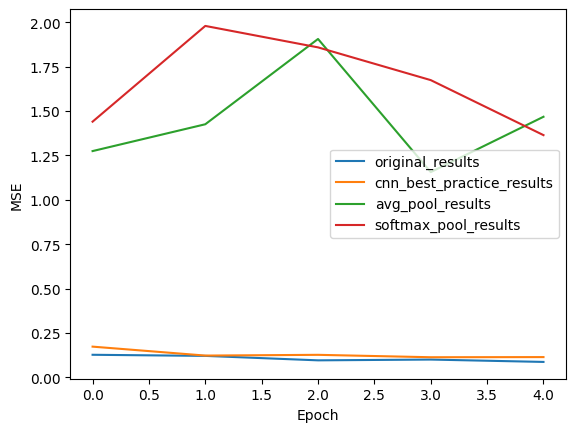

In [82]:
plt.plot(original_results, label="original_results")
plt.plot(cnn_best_practice_results, label="cnn_best_practice_results")
plt.plot(avg_pool_results, label="avg_pool_results")
plt.plot(softmax_pool_results, label="softmax_pool_results")
plt.legend()
plt.ylabel("MSE")
plt.xlabel("Epoch")

Как мы видим побить оригинальные результаты с семинара мне не удалось: 
* Так как я начала использовать дропуат для cnn_best_practice_results возможно стоило дать модели дольше поучиться. Чтобы она перестала опираться на популярные "связки" слов. Но судя по пологости графика она уже особо не училась. 
* Добавление нелинейности в виде ReLU также не дало никакого профита. Возможно данную задачу достаточно решать линейно. 
* Также не дало профита добавления параллельной свертки, с бОльшим размером окна и страйдом. Возможно на моменте pool-инга преимущественно выигрывали активации свертки с мЕньшим окном. 
* Замена макспулинга на его аналоги - средний пулинг и софтмакс также не дало прироста в качестве. Даже ухудшило его. Вкрятно это связано с тем что для принятия решения о классификации достаточно найти хотя бы один однозначный популярный паттерн и пытаться сохранить его высокую активацию именно макспулингом.  